# Train the Generative Model for Candidate Labeling

This notebook is designed to run a generative model that snorkel uses to probabilistically label each candidate. (1 for positive label and -1 for negative label). Using this generative model, we will test the hypothesis: **modeling correlation structure between label functions provides better precision and recall than the conditionally independent model.**

## MUST RUN AT THE START OF EVERYTHING

Import the necessary modules and set up the database for database operations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter, OrderedDict, defaultdict
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc, f1_score

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel import SnorkelSession
from snorkel.annotations import load_gold_labels
from snorkel.annotations import FeatureAnnotator, LabelAnnotator, save_marginals
from snorkel.learning import GenerativeModel
from snorkel.learning.structure import DependencySelector
from snorkel.learning.utils import MentionScorer
from snorkel.models import Candidate, FeatureKey, candidate_subclass, Label
from snorkel.utils import get_as_dict
from tree_structs import corenlp_to_xmltree
from treedlib import compile_relation_feature_generator
from utils.disease_gene_lf import LFS

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load preprocessed data 

This code will load the corresponding label matricies that were generated in the previous notebook ([Notebook 2](2.data-labeler.ipynb)). This notebook has three matricies which are broken down as follows:

|Dataset|Size|Description|
|:-----|-----|:-----|
|L_train|50,000|Randomly sampled from our 2,700,000 training set|
|L_dev|10,000|Randomly sampled from our 700,000 dev set. Only 200 have been hand labeled|
|L_train_labeled|919|Have been hand labled from training set and is separate from (L_train).|

In [6]:
train_candidate_ids = np.loadtxt('data/labeled_candidates.txt').astype(int).tolist()
train_candidate_ids[0:10]

[9951794,
 904609,
 5192262,
 14552559,
 16277239,
 7513663,
 26709637,
 18498661,
 31276326,
 7508019]

In [7]:
dev_data_df = pd.read_excel("data/sentence-labels-dev-hand-labeled.xlsx")
dev_data_df = dev_data_df[dev_data_df.curated_dsh.notnull()]
dev_candidate_ids = list(map(int, dev_data_df.candidate_id.values))
print("Total Hand Labeled Dev Sentences: {}".format(len(dev_candidate_ids)))

Total Hand Labeled Dev Sentences: 210


In [8]:
%%time
labeler = LabelAnnotator(lfs=[])

# Only grab candidates that have labels
cids = session.query(Candidate.id).filter(Candidate.id.in_(train_candidate_ids))
L_train = labeler.load_matrix(session, cids_query=cids)

cids = session.query(Candidate.id).filter(Candidate.id.in_(dev_candidate_ids))
L_dev = labeler.load_matrix(session,cids_query=cids)

CPU times: user 2.33 s, sys: 11.9 ms, total: 2.34 s
Wall time: 2.62 s


In [9]:
sql = '''
SELECT candidate_id FROM gold_label
INNER JOIN Candidate ON Candidate.id=gold_label.candidate_id
WHERE Candidate.split=0;
'''
cids = session.query(Candidate.id).filter(Candidate.id.in_([x[0] for x in session.execute(sql)]))
L_train_labeled = labeler.load_matrix(session, cids_query=cids)
L_train_labeled_gold = load_gold_labels(session, annotator_name='danich1', cids_query=cids)

In [10]:
print("Total Number of Hand Labeled Candidates: {}\n".format(L_train_labeled_gold.shape[0]))
print("Distribution of Labels:")
print(pd.DataFrame(L_train_labeled_gold.toarray(), columns=["labels"])["labels"].value_counts())

Total Number of Hand Labeled Candidates: 919

Distribution of Labels:
-1    473
 1    446
Name: labels, dtype: int64


In [11]:
print("Total Size of Train Data: {}".format(L_train.shape[0]))
print("Total Number of Label Functions: {}".format(L_train.shape[1]))

Total Size of Train Data: 50000
Total Number of Label Functions: 17


# Train the Generative Model

Here is the first step in classifying candidate sentences. We train a generative model to probabilistically label each training sentence. This means the model assigns a probability to each sentence indicating whether or not it mentions a given relatinoship (> 0.5 if yes, 0.5 < if no). The generative model snorkel uses is a [factor graph](http://deepdive.stanford.edu/assets/factor_graph.pdf) and further information on this model can be found in their paper [here](https://arxiv.org/abs/1711.10160).

The following code below trains two different generative models. One model follows the assumption that each label function is independent of each other, while the other model assumes there are dependancies between each function (e.g. $L_{1}$ correlates with $L_{2}$).

In [12]:
%%time
#Conditionally independent Generative Model
indep_gen_model = GenerativeModel()
indep_gen_model.train(
    L_train,
    epochs=30,
    decay=0.95,
    step_size=0.1 / L_train.shape[0],
    reg_param=1e-6,
    threads=50,
)

Inferred cardinality: 2
CPU times: user 1min 34s, sys: 64.6 ms, total: 1min 34s
Wall time: 38.2 s


In [13]:
# select the dependancies from the label matrix
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

61

In [14]:
%%time
# Model each label function and the underlying correlation structure
gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train,
    epochs=30,
    decay=0.95,
    step_size=0.1 / L_train.shape[0],
    reg_param=1e-6,
    threads=50,
    deps=deps
)

Inferred cardinality: 2
CPU times: user 3min 18s, sys: 168 ms, total: 3min 18s
Wall time: 1min 30s


# Generative Model Statistics

Now that both models have been trained, the next step is to generate some statistics about each model. The two histograms below show a difference between both models' output. The conditionally independent model (CI) predicts more negative candidates compared to the dependancy aware model (DA).

In [15]:
# Generate Statistics of Generative Model
indep_learned_stats_df = indep_gen_model.learned_lf_stats()
learned_stats_df = gen_model.learned_lf_stats()

In [16]:
%%time 
train_marginals_indep = indep_gen_model.marginals(L_train)
train_marginals = gen_model.marginals(L_train)

CPU times: user 1min 30s, sys: 98.9 ms, total: 1min 30s
Wall time: 1min 30s


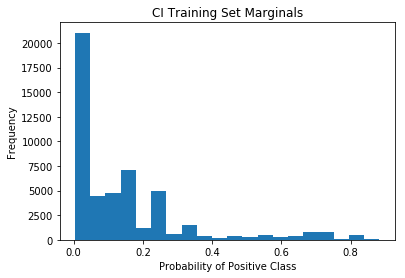

In [17]:
plt.hist(train_marginals_indep, bins=20)
plt.title("CI Training Set Marginals")
plt.ylabel("Frequency")
plt.xlabel("Probability of Positive Class")
plt.show()

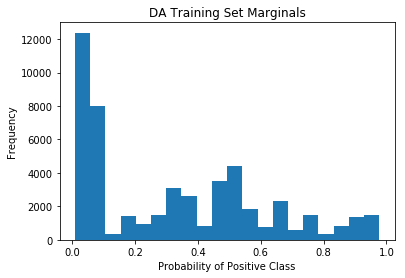

In [18]:
plt.hist(train_marginals, bins=20)
plt.title("DA Training Set Marginals")
plt.ylabel("Frequency")
plt.xlabel("Probability of Positive Class")
plt.show()

# Training Set Statistics

Taking a closer look into the training set predictions, we can see how each label function individually performed. The two dataframes below contain the follwoing information: number of candidate sentences a label function has labeled (coverage), number of candidate sentences a label function agreed with another label function (overlaps), number of candidates a label function disagreed with another label function (conflicts), and lastly, the accuracy each label function has after training the generative model (Learned Acc).

In [19]:
indep_results_df = L_train.lf_stats(session, est_accs=indep_learned_stats_df['Accuracy'])
indep_results_df.head(2)

,j,Coverage,Overlaps,Conflicts,Learned Acc.
LF_HETNET_DISEASES,0,0.40212,0.40212,0.37532,0.598041
LF_HETNET_DOAF,1,0.16650,0.16650,0.15156,0.586740


In [20]:
results_df = L_train.lf_stats(session, est_accs=learned_stats_df['Accuracy'])
results_df.head(2)

,j,Coverage,Overlaps,Conflicts,Learned Acc.
LF_HETNET_DISEASES,0,0.40212,0.40212,0.37532,0.629497
LF_HETNET_DOAF,1,0.16650,0.16650,0.15156,0.629870


The following bar charts below depict the weights the generative model assigns to each label function. The conditional independent model relies heavily on two negative functions, while the dependancy aware model has similar characteristics. Both LF_HETNET_ABSENT AND LF_NO_CONCLUIONS have the highest weight while the distribution of positive functions between both models differs. 

In [21]:
test_df = pd.concat([
    results_df[["Learned Acc."]].assign(model="DA"),
    indep_results_df[["Learned Acc."]].assign(model="CI"), 
])
test_df = test_df.reset_index()
test_df.head(2)

,index,Learned Acc.,model
0,LF_HETNET_DISEASES,0.629497,DA
1,LF_HETNET_DOAF,0.629870,DA


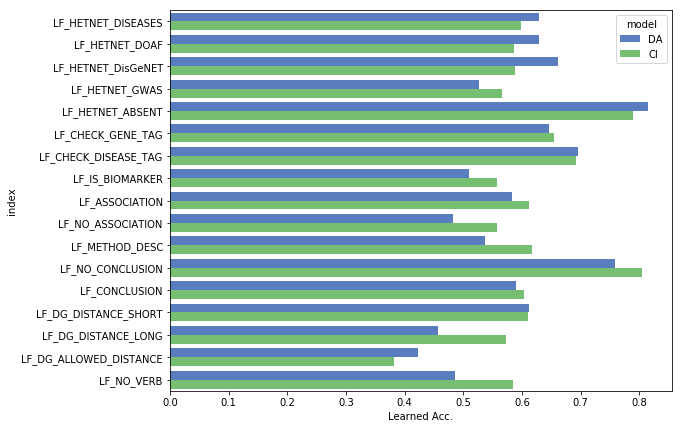

In [22]:
fig, ax = plt.subplots(figsize=(9,7))
sns.barplot(ax=ax,y="index", x="Learned Acc.", hue="model", data=test_df, palette=sns.color_palette("muted"))

## F1 Score of Dev Set

Moving from the training set, we now can look at how well these models can predict our small dev set. Looking at the chart below, the conditionally independent model doesn't perform well compared to the dependency aware model. In terms of f1 score there is about a .2 difference, which provides evidence towards the dependency model performing better.

In [23]:
_ = indep_gen_model.error_analysis(session, L_dev, dev_data_df.curated_dsh.apply(lambda x: -1 if x==0 else x).values)

Scores (Un-adjusted)
Pos. class accuracy: 0.0741
Neg. class accuracy: 0.907
Precision            0.333
Recall               0.0741
F1                   0.121
----------------------------------------
TP: 6 | FP: 12 | TN: 117 | FN: 75



In [24]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_data_df.curated_dsh.apply(lambda x: -1 if x==0 else x).values)

Scores (Un-adjusted)
Pos. class accuracy: 0.259
Neg. class accuracy: 0.62
Precision            0.3
Recall               0.259
F1                   0.278
----------------------------------------
TP: 21 | FP: 49 | TN: 80 | FN: 60



# F1 Score of Train Hand Labeled Set

Looking at the small hand labeled training set we can see a pretty big spike in performance. In terms of f1 score the DA model has about a 0.3 increase in performance comapred to the CI model. 

In [25]:
_ = indep_gen_model.error_analysis(session, L_train_labeled, L_train_labeled_gold)

Scores (Un-adjusted)
Pos. class accuracy: 0.209
Neg. class accuracy: 0.947
Precision            0.788
Recall               0.209
F1                   0.33
----------------------------------------
TP: 93 | FP: 25 | TN: 448 | FN: 353



In [26]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_train_labeled, L_train_labeled_gold)

Scores (Un-adjusted)
Pos. class accuracy: 0.592
Neg. class accuracy: 0.717
Precision            0.663
Recall               0.592
F1                   0.626
----------------------------------------
TP: 264 | FP: 134 | TN: 339 | FN: 182



## Individual Candidate Error Analysis

Depending on which block of code is executed, the following block of code below will show which candidate sentence was incorrectly labeled. Right now the false negatives (fn) are being shown below but this could change to incorporate false positives (fp) as well.

In [27]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fn, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [28]:
sv

SentenceNgramViewer(cids=[[[114], [56, 57, 58, 177, 178, 179], [20]], [[163, 164], [22], [44]], [[113], [54], [12]], [[162], [154, 155, 156, 157], [5]], [[37], [40], [55]], [[0], [39], [87]], [[138, 139], [83], [26]], [[19], [105], [25]], [[132], [46], [10]], [[60, 62], [6], [74]], [[52, 119, 176], [148, 151], [134]], [[76, 77], [34], [159]], [[133], [88, 90], [170]], [[144, 145, 146], [95], [167]], [[181], [160, 161], [102]], [[108], [43, 99], [110]], [[65], [80], [166, 171]], [[136], [30], [92]], [[24], [2], [17]], [[72], [101], [117, 172]], [[75], [81], [27]], [[50], [32, 97], [93]], [[66], [98], [49]], [[169], [9], [140]], [[71], [115, 116], [149]], [[131], [135], [4]], [[104], [23], [165]], [[158], [16], [59, 141, 142]], [[1], [53], [41, 118, 143]], [[51], [84], [13, 94]], [[28, 124], [109], [35]], [[78, 96], [82], [168]], [[21, 153], [11], [126]], [[111, 125], [64, 112, 123], [14]], [[3], [47, 48], [18]], [[73], [173], [130, 137]], [[42], [103, 106, 107], [86]], [[33], [61], [15]], [[29], [127, 128, 129], [7, 8]], [[89], [91], [69]], [[147], [79], [36]], [[85], [121, 122], [38, 152]], [[120], [31], [174]], [[67], [175], [150]], [[70], [68], [100]], [[180], [45], [63]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="814748"><span class="candidate 114 114-1">Thyrotropin-releasing hormone</span><span class=""> (TRH) induced a significant increase in plasma growth hormone (GH) levels in 4 of 8 children with </span><span class="candidate 114 114-0">primary hypothyroidism</span><span class="">, while a slight decrease was observed in 8 control children.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="838061"><span class="">It is suggested that the elevated serum PRL levels of patients with </span><span class="candidate 56 57 58 56-0 57-0 58-0">primary hypothyroidism</span><span class=""> are mediated by feedback-induced </span><span class="candidate 57 179 57-1 179-1">thyrotropin-releasing hormone</span><span class=""> (</span><span class="candidate 58 177 58-1 177-1">TRH)</span><span class=""> secretion or an enhanced response to endogenous </span><span class="candidate 56 178 56-1 178-1">TRH</span><span class="">, and that the combination of delivery and the PRL excess may induce persistent galactorrhea in patients with </span><span class="candidate 177 178 179 177-0 178-0 179-0">primary hypothyroidism</span><span class="">.</span></li>\n\n<li class="list-group-item" data-toggle="

In [29]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

DiseaseGene(Span("b'Hypothyroidism'", sentence=3323208, chars=[0,13], words=[0,0]), Span("b'hormone'", sentence=3323208, chars=[148,154], words=[18,18]))

In [30]:
c.labels

[Label (LF_HETNET_DISEASES = 1),
 Label (LF_CHECK_GENE_TAG = -1),
 Label (LF_NO_CONCLUSION = -1),
 Label (LF_DG_ALLOWED_DISTANCE = 1)]

In [31]:
c.id

243174

## Generate Excel File of Train Data

Lastly we write out the generative model's output into a file. Reason for this will be used in the [next notebook](4.sentence-level-prediction.ipynb), where we aim to use a noise aware discriminator model to correct for the generative models' errors.

In [32]:
def make_sentence_df(lf_matrix, marginals, pair_df):
    rows = list()
    for i in tqdm.tqdm(range(lf_matrix.shape[0])):
        row = OrderedDict()
        candidate = lf_matrix.get_candidate(session, i)
        row['candidate_id'] = candidate.id
        row['disease'] = candidate[0].get_span()
        row['gene'] = candidate[1].get_span()
        row['doid_id'] = candidate.Disease_cid
        row['entrez_gene_id'] = candidate.Gene_cid
        row['sentence'] = candidate.get_parent().text
        row['label'] = marginals[i]
        rows.append(row)
    sentence_df = pd.DataFrame(rows)
    sentence_df['entrez_gene_id'] = sentence_df.entrez_gene_id.astype(int)
    sentence_df = pd.merge(
        sentence_df,
        pair_df[["doid_id", "entrez_gene_id", "doid_name", "gene_symbol"]],
        on=["doid_id", "entrez_gene_id"],
        how="left"
    )
    sentence_df = pd.concat([
        sentence_df,
        pd.DataFrame(lf_matrix.todense(), columns=list(LFS))
    ], axis='columns')
    return sentence_df

In [33]:
pair_df = pd.read_csv("data/disease-gene-pairs-association.csv.xz", compression='xz')
pair_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.85860,1
1,1,A1BG,DOID:1319,brain cancer,NaN,0,0,0,0.36785,0


In [34]:
train_sentence_df = make_sentence_df(L_train, train_marginals, pair_df)
train_sentence_df.head(2)

100%|██████████| 50000/50000 [04:27<00:00, 186.61it/s]


,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence,label,doid_name,gene_symbol,LF_HETNET_DISEASES,...,LF_IS_BIOMARKER,LF_ASSOCIATION,LF_NO_ASSOCIATION,LF_METHOD_DESC,LF_NO_CONCLUSION,LF_CONCLUSION,LF_DG_DISTANCE_SHORT,LF_DG_DISTANCE_LONG,LF_DG_ALLOWED_DISTANCE,LF_NO_VERB
0,21445,Presenile dementia,Pick,DOID:10652,9463,"Presenile dementia with Alzheimer-, Pick- and ...",0.018774,Alzheimer's disease,PICK1,0,...,0,0,0,0,-1,0,-1,0,0,-1
1,21497,epilepsy,ACTH,DOID:1826,5443,EEG with intravenous diazepam is valuable for ...,0.677368,epilepsy syndrome,POMC,1,...,0,0,0,0,-1,0,0,0,1,0


In [35]:
writer = pd.ExcelWriter('data/sentence-labels.xlsx')
(train_sentence_df
    .to_excel(writer, sheet_name='sentences', index=False)
)
if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)
writer.close()

## Generate Excel File of Dev Data

In [ ]:
dev_sentence_df = make_sentence_df(L_dev, dev_marginals, pair_df)
dev_sentence_df.head(2)

In [ ]:
writer = pd.ExcelWriter('data/sentence-labels-dev.xlsx')
(dev_sentence_df
    .sample(frac=1, random_state=100)
    .to_excel(writer, sheet_name='sentences', index=False)
)
if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)
writer.close()